# Twitter Sentiment Analysis


In [3]:
# DataFrame
import pandas as pd
import numpy as np

# Visual
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2Vec
import gensim

# Utility
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Settings

In [ ]:
# DATASET
# DATASET_COLUMNS = ['target', 'ids', 'date', 'flag', 'user', 'text']
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT_CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = 'POSITIVE'
NEGATIVE = 'NEGATIVE'
NEUTRAL = 'NEUTRAL'
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
PATH = '/content/drive/MyDrive/Data Science/Models/twitter_sentiment_model'
KERAS_MODEL = "model"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

Load a reduced version of the twitter sentiment dataset "training.1600000.processed.noemoticon.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data Science/Datasets/twitter200000.csv', encoding = DATASET_ENCODING)

# Exploratory Data Analysis

In [ ]:
print("Dataset size: ", len(df))

Dataset size:  200000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Map target label to string


*   0 to Negative 
*   2 to Neutral
*   4 to Positive

In [ ]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
  return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 48.6 ms, sys: 1.21 ms, total: 49.9 ms
Wall time: 50.6 ms


Text(0.5, 1.0, 'Dataset labels distribution')

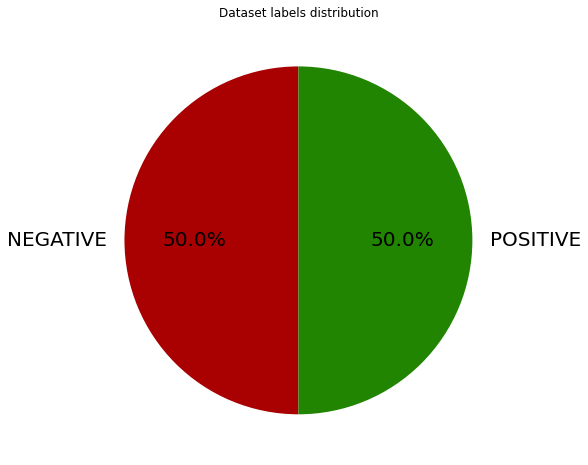

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.pie(target_cnt.values(), labels = target_cnt.keys(), colors=['#a90101', '#218501'], startangle=90, autopct='%.1f%%', textprops={'fontsize': 20})
plt.title("Dataset labels distribution")

# Data Pre-Processing

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return ' '.join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

Train-test split

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=12)

In [ ]:
print('Train size: ', len(df_train))
print('Test size: ', len(df_test))

Train size:  160000
Test size:  40000


# Word to vector

In [ ]:
documents = [_text.split() for _text in df_train.text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW,min_count=W2V_MIN_COUNT, workers=8)

In [ ]:
%%time
w2v_model.build_vocab(documents)

CPU times: user 3.04 s, sys: 42.8 ms, total: 3.08 s
Wall time: 4.31 s


In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Words in vocab ", vocab_size)

Words in vocab  8712


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 58s, sys: 679 ms, total: 1min 58s
Wall time: 1min 29s


(30488727, 36790368)

In [ ]:
w2v_model.most_similar('computer')

<ipython-input-28-8d0df74bf473>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar('computer')


[('laptop', 0.5333189964294434),
 ('comp', 0.47303444147109985),
 ('pc', 0.4508424997329712),
 ('vista', 0.4195903539657593),
 ('battery', 0.4023146629333496),
 ('ipod', 0.4002947211265564),
 ('aim', 0.37880727648735046),
 ('mouse', 0.37199074029922485),
 ('file', 0.36903664469718933),
 ('blackberry', 0.36684566736221313)]

In [ ]:
w2v_model.save(PATH+WORD2VEC_MODEL)

# Tokenize Text

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words: ", vocab_size)

Total words:  74338


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

# Label Encoder

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print('y_train', y_train.shape)
print('y_test', y_test.shape)

y_train (160000, 1)
y_test (40000, 1)


# Embedding Layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(74338, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model

In [ ]:
model=Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          22301400  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 22,461,901
Trainable params: 160,501
Non-trainable params: 22,301,400
_________________________________________________________________


# Compile Model, Callbacks

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# Train Model

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)

Epoch 1/8
141/141 [==============================] - 210s 1s/step - loss: 0.5595 - accuracy: 0.7103 - val_loss: 0.5193 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 2/8
141/141 [==============================] - 199s 1s/step - loss: 0.5248 - accuracy: 0.7367 - val_loss: 0.5070 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 3/8
141/141 [==============================] - 201s 1s/step - loss: 0.5121 - accuracy: 0.7460 - val_loss: 0.5052 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 4/8
141/141 [==============================] - 197s 1s/step - loss: 0.5034 - accuracy: 0.7508 - val_loss: 0.5029 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 5/8
141/141 [==============================] - 197s 1s/step - loss: 0.4979 - accuracy: 0.7559 - val_loss: 0.4984 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 6/8
141/141 [==============================] - 195s 1s/step - loss: 0.4917 - accuracy: 0.7590 - val_loss: 0.4962 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 7/8
141/141 [==============================] - 199s 1s/step - lo

In [ ]:
model.save(PATH+KERAS_MODEL)

# Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print('Accuracy:', score[1])
print('Loss', score[0])

40/40 [==============================] - 4s 105ms/step - loss: 0.4906 - accuracy: 0.7661

Accuracy: 0.7661499977111816
Loss 0.49058565497398376
CPU times: user 3.98 s, sys: 174 ms, total: 4.15 s
Wall time: 4.4 s


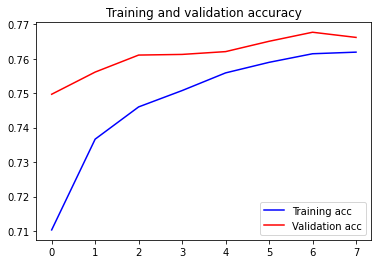

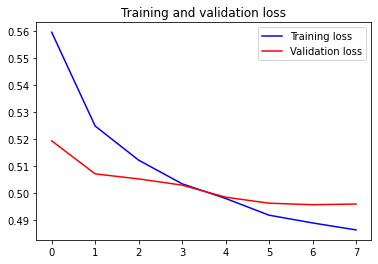

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
  if include_neutral:
    label = NEUTRAL
    if score <= SENTIMENT_THRESHOLDS[0]:
      label = NEGATIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
      label = POSITIVE
    return label
  else:
    return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
  start_at = time.time()
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
  score = model.predict([x_test])[0]
  label = decode_sentiment(score, include_neutral=include_neutral)

  return {'label': label, 'score': float(score), 'elapsed_time': time.time()-start_at}

In [ ]:
predict("I love everyone in the world")

1/1 [==============================] - 0s 335ms/step


{'label': 'POSITIVE',
 'score': 0.9903332591056824,
 'elapsed_time': 0.4205324649810791}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 4s 100ms/step
CPU times: user 4.38 s, sys: 180 ms, total: 4.56 s
Wall time: 5.42 s


# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

  plt.ylabel('True label', fontsize=25)
  plt.xlabel('Predicted label', fontsize=25)

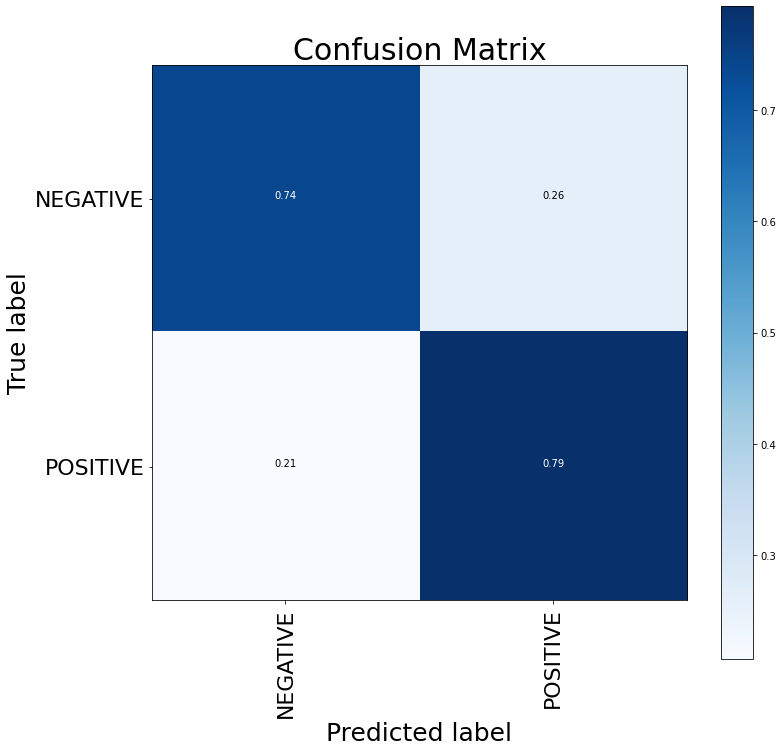

In [ ]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title='Confusion Matrix')
plt.show()

# Classification Report and Accuracy Score


In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.74      0.76     19966
    POSITIVE       0.75      0.79      0.77     20034

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.76615

# Save Model

In [ ]:
model.save(PATH+KERAS_MODEL)
w2v_model.save(PATH+WORD2VEC_MODEL)
pickle.dump(tokenizer, open(PATH+TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(PATH+ENCODER_MODEL, "wb"), protocol=0)